In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
employee = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/15.diversity/employee.csv')
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [3]:
company_hierarchy = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/15.diversity/company_hierarchy.csv')
company_hierarchy.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [4]:
data = pd.merge(left=employee, right=company_hierarchy, on='employee_id')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


### Question 1

In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

    - Individual Contributors (IC) - they don't manage anyone
    - Middle Managers (MM) - they are the direct bosses of IC
    - Directors (D) - they are the direct bosses of MM
    - VP - D direct bosses
    - Executives (E) - VP direct bosses
    - CEO - The direct boss of E.

In [5]:
data['dept'].unique()

array(['engineering', 'sales', 'HR', 'marketing', 'CEO'], dtype=object)

In [6]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data.loc[data['dept'] == 'CEO', 'level'] = 'CEO'

for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = data[data['level'] == boss_level]['employee_id']
    data.loc[data['boss_id'].isin(boss_id), 'level'] = empl_level

In [7]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC


In [8]:
# value counts for each group
data['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

### Question 2
How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [9]:
# find the managed employees for each employee
data['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = data[data['level'] == level]['boss_id']
    employee_ids = data[data['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + data.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(data.loc[data['employee_id'] == b_id, 'counts'])
        data.loc[data['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [10]:
data.head(10)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0
5,91334,0,221000.0,PhD,F,2,62990.0,sales,IC,0
6,101901,1,194000.0,PhD,M,12,7558.0,engineering,MM,6
7,171111,1,119000.0,Master,F,1,30468.0,engineering,IC,0
8,23443,1,217000.0,PhD,M,8,130585.0,sales,IC,0
9,24195,0,230000.0,Master,M,4,1050.0,engineering,IC,0


### Question 3
Build a model to predict the salary of each employee.

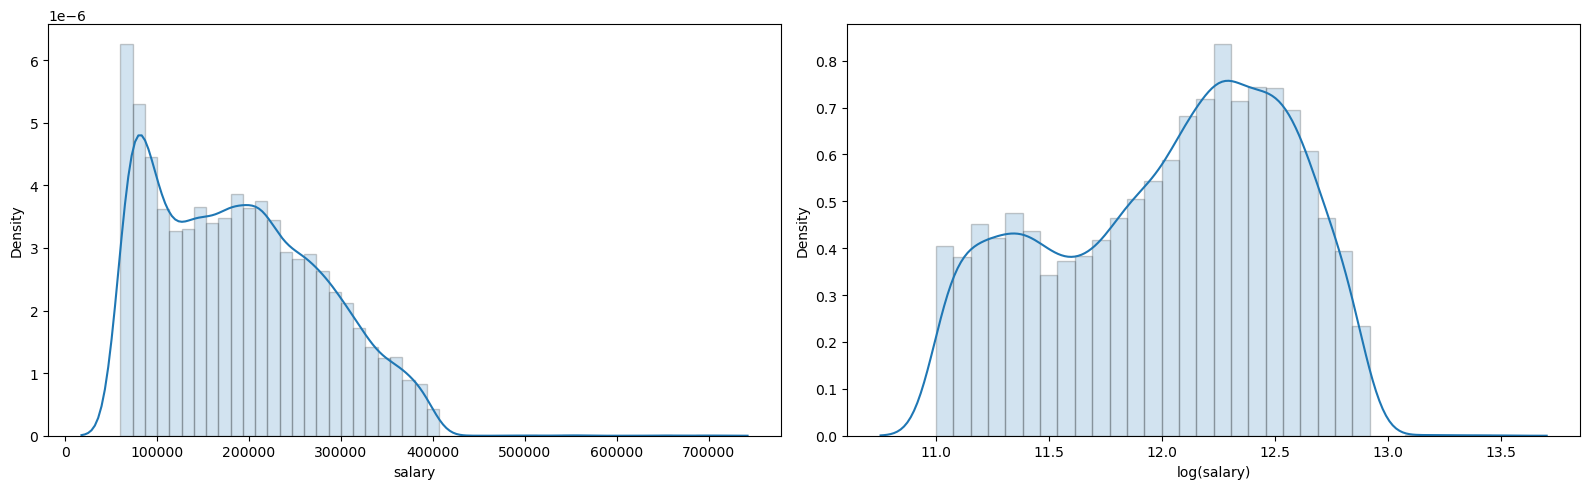

In [11]:
# Distribution of salary
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(data['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(data['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

From the left plot above, we can see that salary's distribution is highly skewed, which would increase difficulty on regression. Hence, we use log transform as our target value.

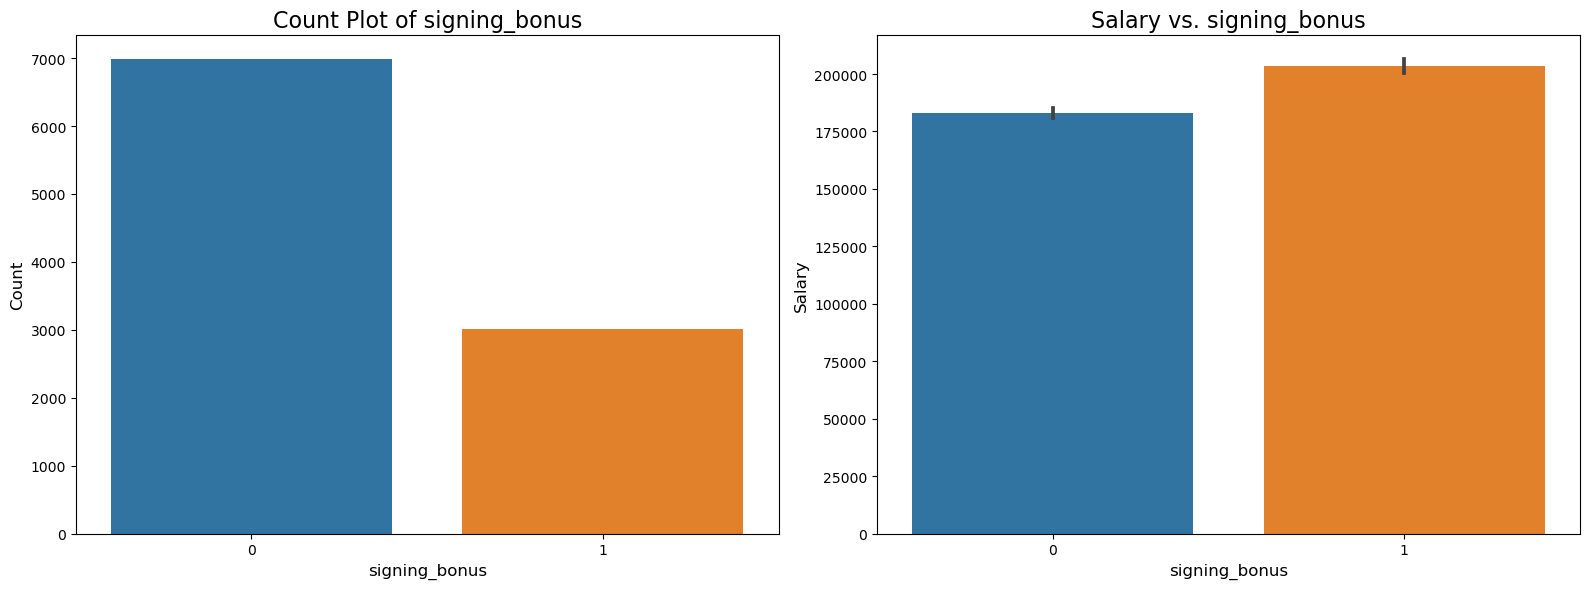

In [12]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

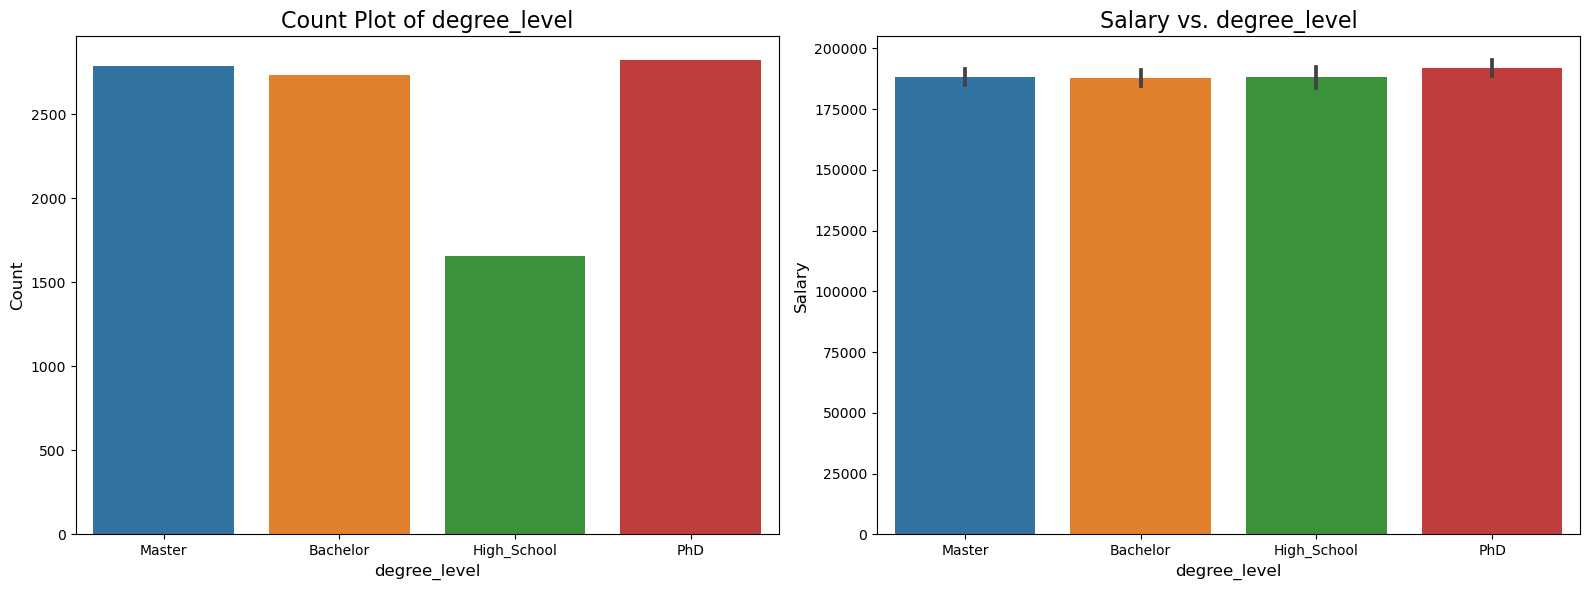

In [13]:
# visualization of 'degree_level'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree_level', data=data, ax=ax[0])
ax[0].set_xlabel('degree_level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('degree_level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree_level', fontsize=16)
plt.tight_layout()
plt.show()

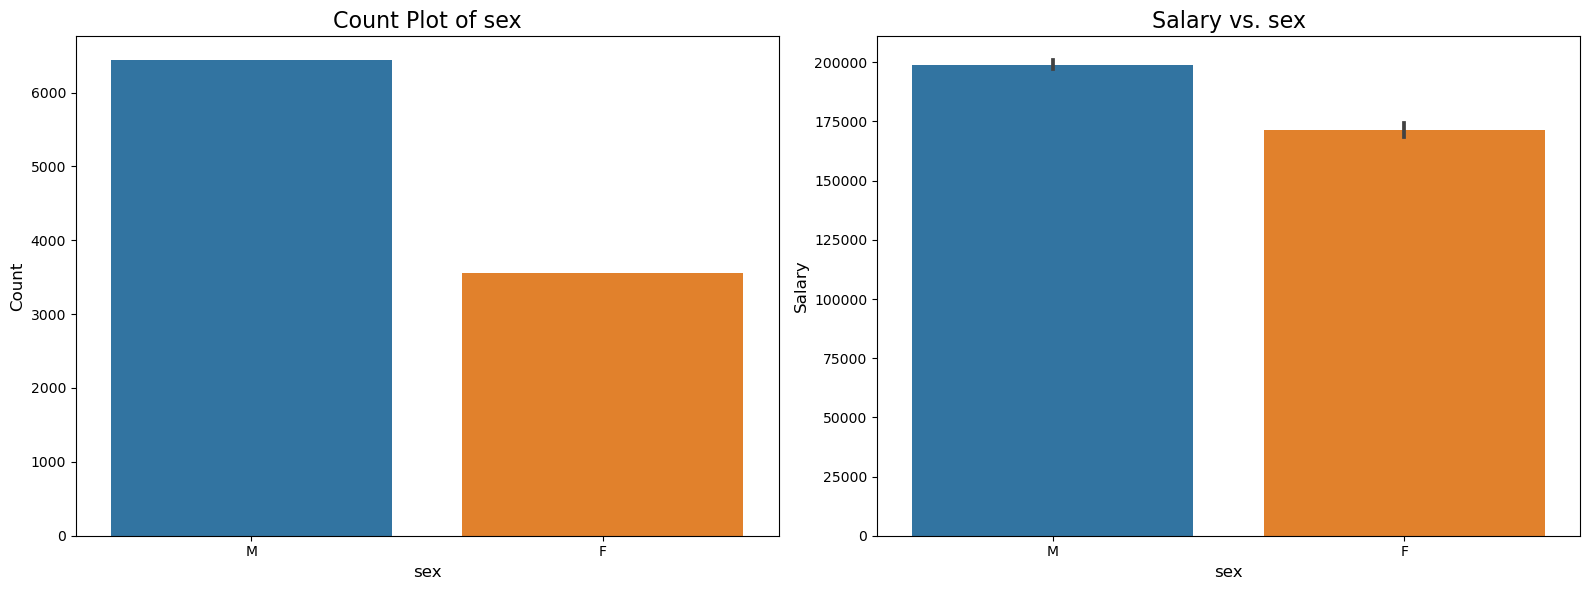

In [14]:
# visualization of 'sex'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_xlabel('sex', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('sex', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. sex', fontsize=16)
plt.tight_layout()
plt.show()

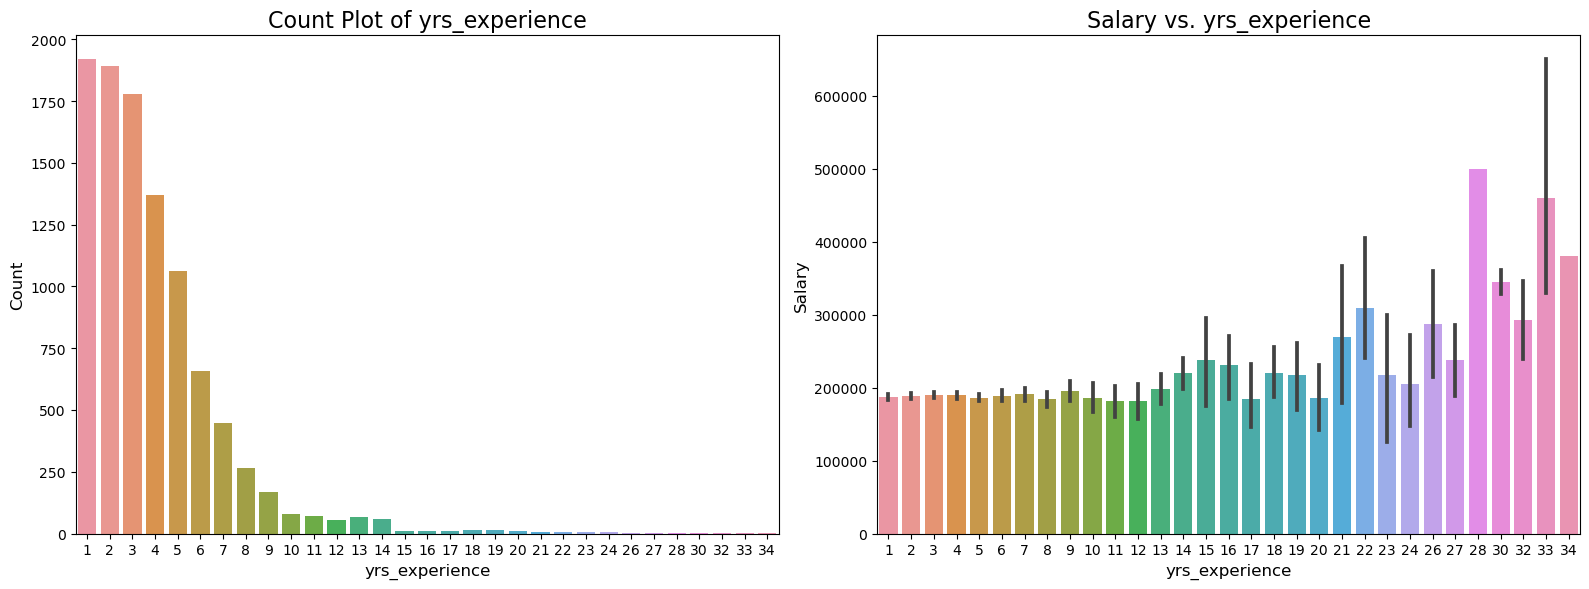

In [15]:
# visualization of 'yrs_experience'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='yrs_experience', data=data, ax=ax[0])
ax[0].set_xlabel('yrs_experience', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. yrs_experience', fontsize=16)
plt.tight_layout()
plt.show()

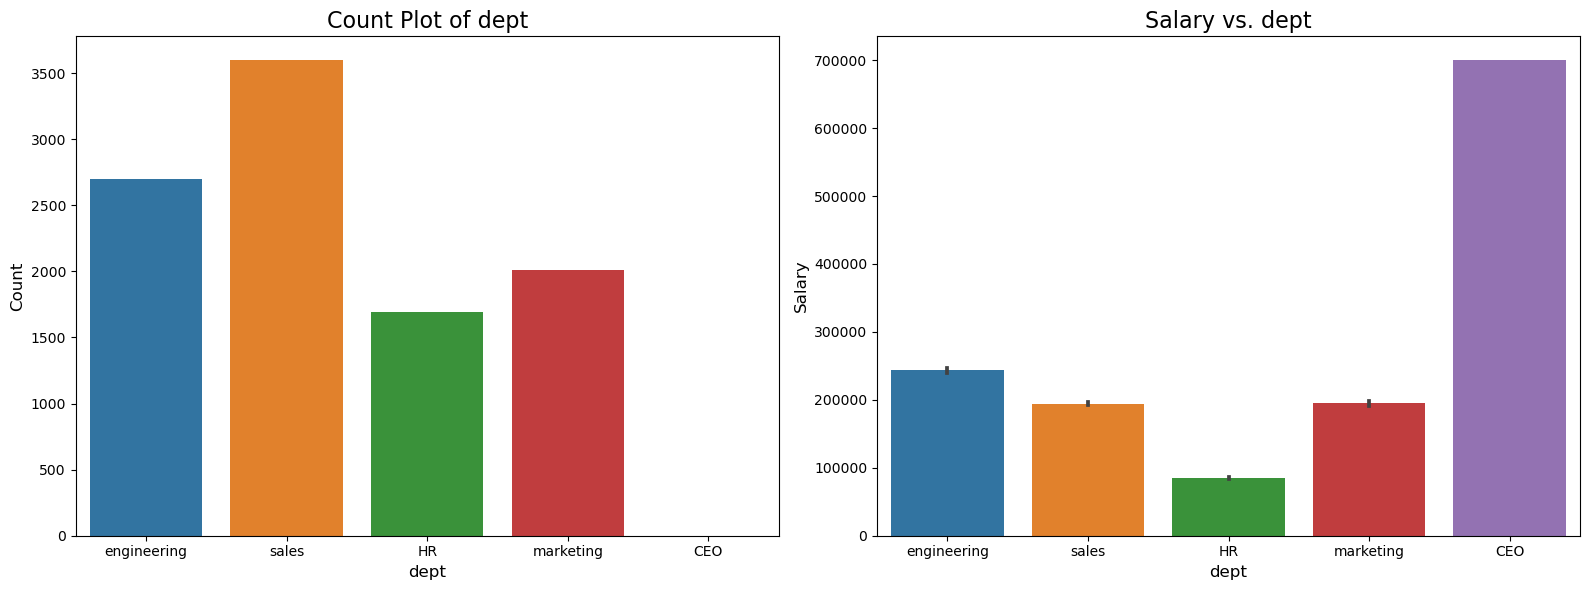

In [16]:
# visualization of 'dept'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dept', data=data, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. dept', fontsize=16)
plt.tight_layout()
plt.show()

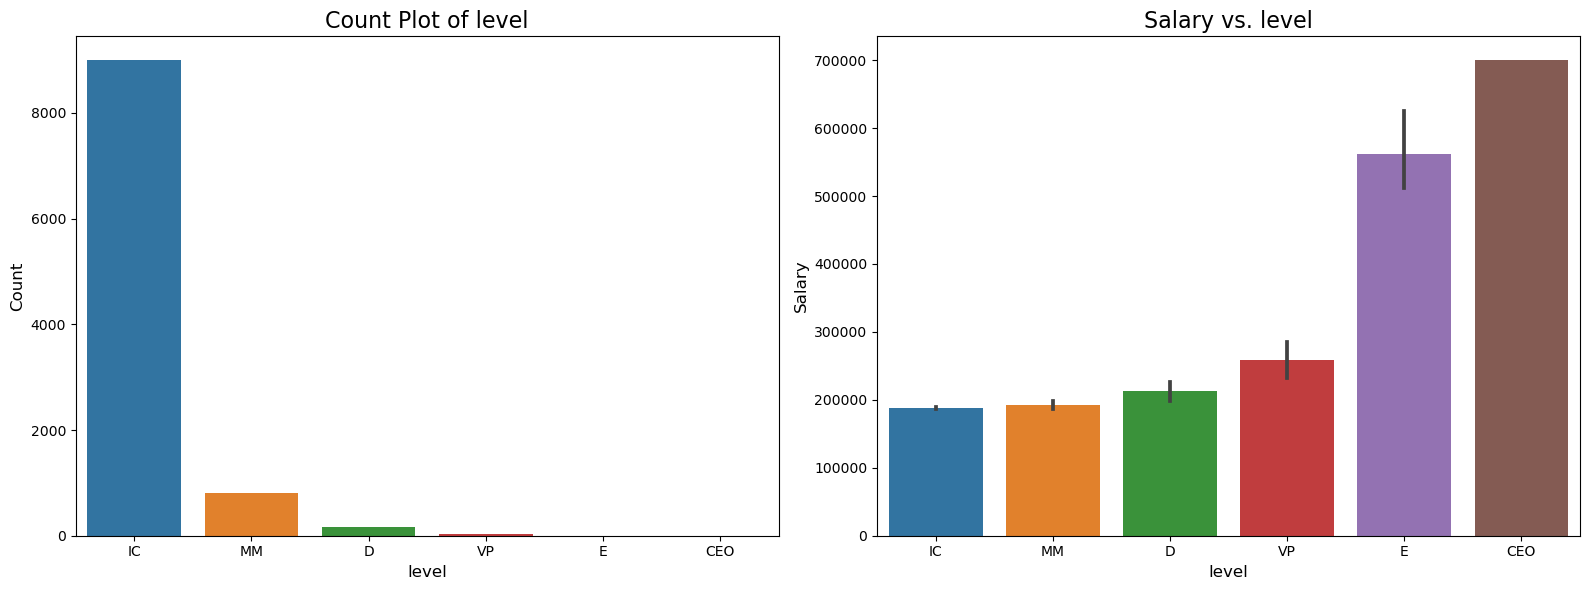

In [17]:
# visualization of 'signing_bonus'
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='level', data=data, ax=ax[0], order=orders)
ax[0].set_xlabel('level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level', fontsize=16)

sns.barplot(x='level', y='salary', data=data, ax=ax[1], order=orders)
ax[1].set_xlabel('level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()

##### Remove outliers

In [18]:
data.groupby('level')['salary'].agg(['count','mean']).sort_values(by='count')

,count,mean
level,,
CEO,1,700000.000000
E,4,562500.000000
VP,35,258028.571429
D,160,212343.750000
MM,800,192473.750000
IC,9000,187909.222222


From the table above, we can see there is only one CEO, and his salary is much higher than any other employees in this company.

When we split the data into training/test sets, no matter which set contains CEO, his high salary will impact significantly the result. Hence, we consider CEO as outlier, and remove it from the data set.

In [19]:
data = data[data['dept'] != 'CEO']

In [20]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


In [21]:
data['is_male'] = (data['sex'] == 'M').astype(int)
del data['sex']

data.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,boss_id,dept,level,counts,is_male
0,138719,0,273000.0,Master,2,43602.0,engineering,IC,0,1
1,3192,0,301000.0,Bachelor,1,87847.0,sales,IC,0,0
2,114657,0,261000.0,Master,2,180854.0,sales,IC,0,0
3,29039,0,86000.0,High_School,4,88370.0,HR,IC,0,0
4,118607,0,126000.0,Bachelor,3,23565.0,sales,IC,0,0


In [22]:
# transform 'level' into numbers
# ORDER matters
level_lst = ['IC','MM','D','VP','E','CEO']
level_index = {l:index for index,l in enumerate(level_lst)}
data['level'] = data.level.map(level_index)

data.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,boss_id,dept,level,counts,is_male
0,138719,0,273000.0,Master,2,43602.0,engineering,0,0,1
1,3192,0,301000.0,Bachelor,1,87847.0,sales,0,0,0
2,114657,0,261000.0,Master,2,180854.0,sales,0,0,0
3,29039,0,86000.0,High_School,4,88370.0,HR,0,0,0
4,118607,0,126000.0,Bachelor,3,23565.0,sales,0,0,0


In [23]:
# transform 'educational degree' into numbers
# ORDER matters
degree_lst = ['High_School','Bachelor','Master','PhD']
degree_index = {d:index for index,d in enumerate(degree_lst)}
data['degree_level'] = data.degree_level.map(degree_index)

data.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,boss_id,dept,level,counts,is_male
0,138719,0,273000.0,2,2,43602.0,engineering,0,0,1
1,3192,0,301000.0,1,1,87847.0,sales,0,0,0
2,114657,0,261000.0,2,2,180854.0,sales,0,0,0
3,29039,0,86000.0,0,4,88370.0,HR,0,0,0
4,118607,0,126000.0,1,3,23565.0,sales,0,0,0


In [24]:
del data['boss_id'] # I assume boss_id won't affect salary

In [25]:
# encoding 'dept'
encoder = LabelEncoder()
data['dept'] = encoder.fit_transform(data['dept'])

data.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,dept,level,counts,is_male
0,138719,0,273000.0,2,2,1,0,0,1
1,3192,0,301000.0,1,1,3,0,0,0
2,114657,0,261000.0,2,2,3,0,0,0
3,29039,0,86000.0,0,4,0,0,0,0
4,118607,0,126000.0,1,3,3,0,0,0


In [26]:
data['salary'] = np.log(data['salary'])

data.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,dept,level,counts,is_male
0,138719,0,12.517227,2,2,1,0,0,1
1,3192,0,12.614866,1,1,3,0,0,0
2,114657,0,12.472276,2,2,3,0,0,0
3,29039,0,11.362103,0,4,0,0,0,0
4,118607,0,11.744037,1,3,3,0,0,0


In [27]:
y = data['salary']

In [28]:
X = data[['signing_bonus', 'degree_level', 'yrs_experience', 'dept', 'level', 'counts', 'is_male']]

In [29]:
seed = 12
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3,random_state=seed)

In [30]:
Xtrain.level.value_counts()

0    6314
1     556
2     101
3      26
4       2
Name: level, dtype: int64

In [31]:
Xtest.level.value_counts()

0    2686
1     244
2      59
3       9
4       2
Name: level, dtype: int64

We can see that, after splitting, even the smallest group 'level=E' has representives in ** both ** groups. Hence, the splitting is valid to be used to train and evaluate.

In [32]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [33]:
params = {}
params['silent'] = 1
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
# params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[11:56:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } are not used.

[11:56:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } are not used.

[11:56:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-

In [34]:
n_best_trees = cv_results.shape[0]
n_best_trees

60

In [35]:
# re-train on all the data
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[11:56:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:56:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_rounds", "silent" } are not used.

[0]	train-rmse:10.38962
[1]	train-rmse:9.35237
[2]	train-rmse:8.41949
[3]	train-rmse:7.57999
[4]	train-rmse:6.82462
[5]	train-rmse:6.14459
[6]	train-rmse:5.53284
[7]	train-rmse:4.98299
[8]	train-rmse:4.48820
[9]	train-rmse:4.04376
[10]	train-rmse:3.64373
[11]	train-rmse:3.28453
[12]	train-rmse:2.96106
[13]	train-rmse:2.67064
[14]	train-rmse:2.40927
[15]	train-rmse:2.17536
[16]	train-rmse:1.96531
[17]	train-rmse:1.77686
[18]	train-rmse:1.60825
[19]	train-rmse:1.45772
[20]	train-rmse:1.32308
[21]	train-rmse:1.20303
[22]	train-rmse

In [36]:
ytest_pred = gbt.predict(test_matrix, ntree_limit=n_best_trees)
np.sqrt(mean_squared_error(ytest,ytest_pred))

0.3961172735027452

We can see that training RMSE is 0.380, and test set RMSE is 0.396, the difference isn't very high.

<AxesSubplot:>

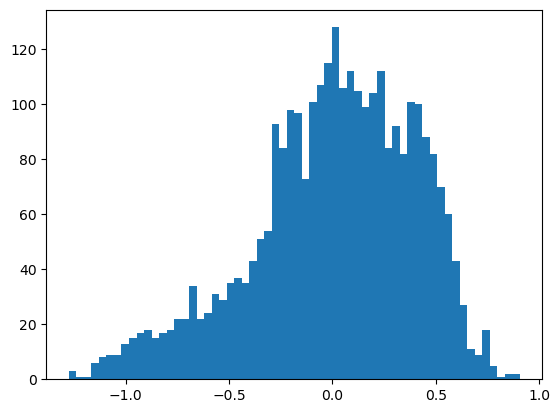

In [37]:
# check residual's distribution
(ytest - ytest_pred).hist(bins=60, grid=False)

From the plot above, we can see that residuals' distribution is nearly normal, although a little skewed. Hence, the trained model is acceptable.

### Question 4

Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

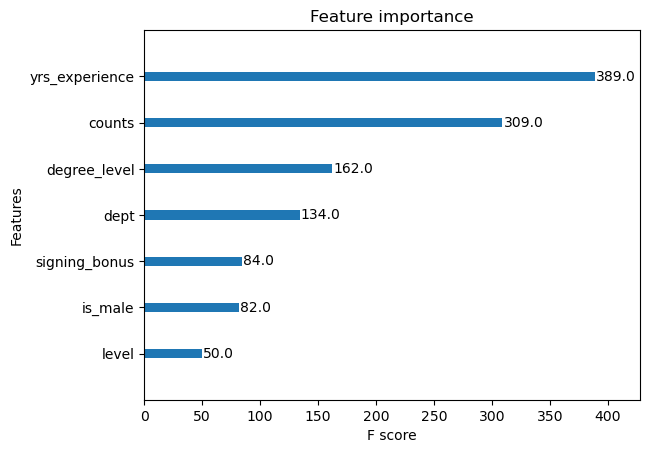

In [38]:
xgb.plot_importance(gbt, grid=False)

'years of experience' is the most important factor of employee salaries.

##### Residuals Analysis

In [39]:
# predict on all data (except CEO) and calculate the bias
whole_matrix = xgb.DMatrix(X)
ypred = gbt.predict(whole_matrix)

# since our prediction is log(salary), so we need to exp it to get the original salary (unit: k)
predresult = pd.DataFrame({'ytrue': np.exp(y),'ypred': np.exp(ypred)})

# if bias >0, means, that employee is over paid
# otherwise, bias<0, means that employee is under paid
predresult['bias'] = predresult.ytrue - predresult.ypred

In [40]:
# join with employee's features
predresult = predresult.join(data)
predresult.head() # glance

,ytrue,ypred,bias,employee_id,signing_bonus,salary,degree_level,yrs_experience,dept,level,counts,is_male
0,273000.0,217287.296875,55712.703125,138719,0,12.517227,2,2,1,0,0,1
1,301000.0,168229.093750,132770.906250,3192,0,12.614866,1,1,3,0,0,0
2,261000.0,176030.578125,84969.421875,114657,0,12.472276,2,2,3,0,0,0
3,86000.0,80173.273438,5826.726562,29039,0,11.362103,0,4,0,0,0,0
4,126000.0,174884.046875,-48884.046875,118607,0,11.744037,1,3,3,0,0,0


<AxesSubplot:>

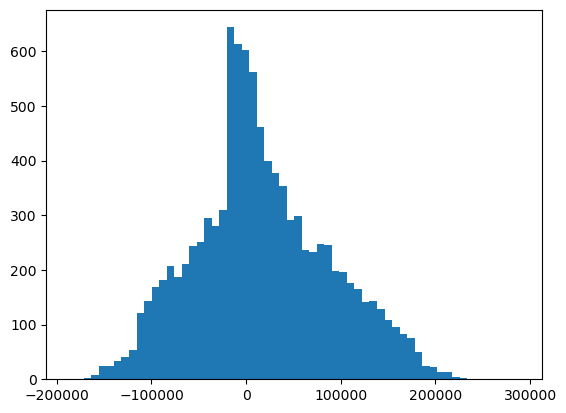

In [41]:
predresult.bias.hist(bins=60, grid=False)

Bias is nearly normal.

Text(0, 0.5, 'bias')

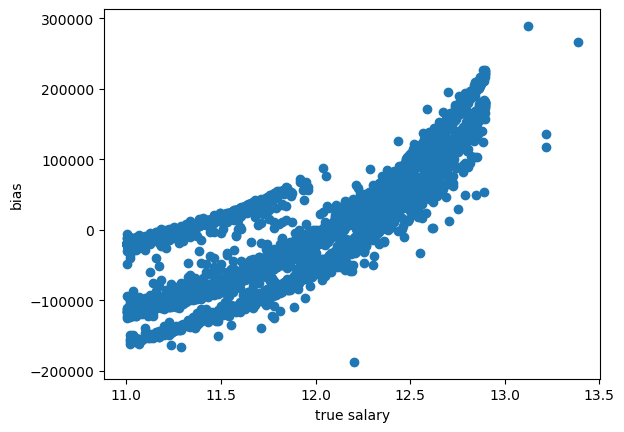

In [42]:
plt.scatter(predresult.salary,predresult.bias)
plt.xlabel("true salary")
plt.ylabel("bias")

From the plot above, we can see that, employee with higher salary are more likely to be overpaid.

In [43]:
def chisquare_test_on_bias():
    X = predresult.copy()
    
    del X['employee_id']
    del X['ytrue']
    del X['ypred']
    del X['salary']
    
    y = (X.bias > 0)
    del X['bias']
    
    scores,pvalues = chi2(X,y)
    return pd.DataFrame({'score': scores, 'pvalue': pvalues},index = X.columns).sort_values(by='pvalue')

In [44]:
chisquare_test_on_bias()

,score,pvalue
counts,4722.535510,0.000000
dept,8.123042,0.004371
level,6.832721,0.008950
yrs_experience,5.582123,0.018145
signing_bonus,1.241159,0.265248
is_male,1.177378,0.277890
degree_level,0.811756,0.367602


'counts', 'dept', 'level' are three factors impacting whether the employee is overpaid or underpaid.

Text(0, 0.5, 'bias')

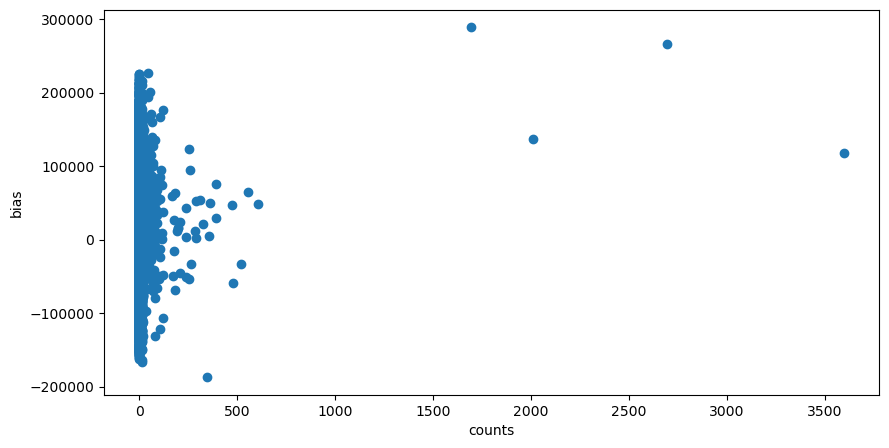

In [45]:
plt.figure(figsize=(10,5))
plt.scatter(predresult.counts,predresult.bias)
plt.xlabel('counts')
plt.ylabel('bias')

From the plot above, we can see that more subordinates, more positive bias, means more likely to be overpaid. We may suggest Head of HR to consider lower down the salaries in high management level, which may be more fair to the workforce.